In [2]:
import numpy as np              
import pandas as pd             
import matplotlib.pyplot as plt  
import keras                     
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint  
import os
import copy
import cv2 as cv


In [3]:
import numpy as np
base_path = "D:/Datasets/udacity_car_simulation_dataset/track1data/"
img_path = base_path + "IMG/"

IMG_SHAPE = (66,200,3)    # This is what we get from the simulator

In [4]:
os.listdir(base_path)


['driving_log.csv', 'IMG', 'simulator']

# Getting Dataframe / csv file 

In [5]:
df = pd.read_csv(base_path + "driving_log.csv")
df.columns = ["center","left","right","steering","throttle","break","speed"]
print(len(df),"\n")

print(len(df)*3)
len(os.listdir(base_path + "IMG"))
df.head()        


10614 

31842


,center,left,right,steering,throttle,break,speed
0,Desktop\track1data\IMG\center_2019_04_02_19_25...,Desktop\track1data\IMG\left_2019_04_02_19_25_3...,Desktop\track1data\IMG\right_2019_04_02_19_25_...,0.0,0.000000,0,0.000007
1,Desktop\track1data\IMG\center_2019_04_02_19_25...,Desktop\track1data\IMG\left_2019_04_02_19_25_3...,Desktop\track1data\IMG\right_2019_04_02_19_25_...,0.0,0.000000,0,0.000003
2,Desktop\track1data\IMG\center_2019_04_02_19_25...,Desktop\track1data\IMG\left_2019_04_02_19_25_3...,Desktop\track1data\IMG\right_2019_04_02_19_25_...,0.0,0.048016,0,0.002267
3,Desktop\track1data\IMG\center_2019_04_02_19_25...,Desktop\track1data\IMG\left_2019_04_02_19_25_3...,Desktop\track1data\IMG\right_2019_04_02_19_25_...,0.0,0.281203,0,0.175589
4,Desktop\track1data\IMG\center_2019_04_02_19_25...,Desktop\track1data\IMG\left_2019_04_02_19_25_3...,Desktop\track1data\IMG\right_2019_04_02_19_25_...,0.0,0.091236,0,0.287728


# Steering Angle Analysis

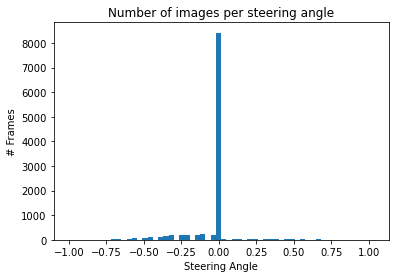

In [6]:
binwidth = 0.035

# histogram before image augmentation
plt.hist(df.steering,bins=np.arange(min(df.steering), max(df.steering) + binwidth, binwidth))
plt.title('Number of images per steering angle')
plt.xlabel('Steering Angle')
plt.ylabel('# Frames')
plt.show()


We have a very biased dataset in our hands here. We have tons of samples for steering angle 0.0 compared to all other steering angles combined. This is quite understandable as steering angle 0.0 corresponds to car going straight. During the "training mode" in track-1 most of the road is straight with occassional curves and turns. There isn't enough samples in the training dataset for non-zero steering angles. If we train our car with this dataset, it will surely learn just to drive straight and never (or struggle) to make turns.

# Get output angles and paths of all images

In [15]:
img_paths = list(df[['left','right','center']].values)
for i in range(0,len(img_paths)):
    for j in range(0,3):
        img_paths[i][j] = img_paths[i][j].split("IMG")[1][1:]
    
output = np.array(df['steering'].values)

# Creating Model

In [8]:
# strides is the dimention by which our convolutional kernel moves forward to convolve next matrix
from keras.optimizers import SGD,Adam
adm = Adam(lr = 0.001)

def get_model():
    model = Sequential()             

    model.add(Conv2D(24, kernel_size=(5,5), activation='relu',input_shape = IMG_SHAPE, strides=(2, 2))) 
    model.add(Conv2D(36, kernel_size=(5,5), activation='relu', strides=(2, 2))) 
    model.add(Conv2D(48, kernel_size=(4,4), activation='relu',strides=(2, 2))) 
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu')) 
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu')) 
    model.add( Flatten() )
    model.add( Dense(100, activation = 'relu') )
    model.add( Dense(50, activation = 'relu') )
    model.add( Dense(10,activation='relu') )
    model.add( Dense(1) )
    model.summary() 

    model.compile(loss='mean_squared_error',optimizer = adm)

    return model


In [9]:
model = get_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 22, 48)         27696     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)              

# Preprocessing Since DataSet isn't Balanced

# Function to read Image

In [10]:
def read_image(path):
    img = cv.imread(path)
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    return np.array(img)


# Minor Processing

In [11]:
# crop the surroundings and the front part of car that shows up in image

def crop_image(img):
    return img[62:-25,:]

def resize_image(img):
    return cv.resize(img,(200,66))

def flip_image(img,angle):
    flipp = np.random.choice(2)
    if flipp==1:
        img = cv.flip(img,1)
        angle = -angle
    
    return img,angle

def plot(img):
    plt.imshow(img)
    plt.show()
    

# Advanced Processing

In [12]:
def add_random_shadow(img, w_low=0.6, w_high=0.85):
    """
    Overlays supplied image with a random shadow polygon
    The weight range (i.e. darkness) of the shadow can be configured via the interval [w_low, w_high)
    """
    cols, rows = (img.shape[0], img.shape[1])
    
    top_y = np.random.random_sample() * rows
    bottom_y = np.random.random_sample() * rows
    bottom_y_right = bottom_y + np.random.random_sample() * (rows - bottom_y)
    top_y_right = top_y + np.random.random_sample() * (rows - top_y)
    if np.random.random_sample() <= 0.5:
        bottom_y_right = bottom_y - np.random.random_sample() * (bottom_y)
        top_y_right = top_y - np.random.random_sample() * (top_y)

    poly = np.asarray([[ [top_y,0], [bottom_y, cols], [bottom_y_right, cols], [top_y_right,0]]], dtype=np.int32)
        
    mask_weight = np.random.uniform(w_low, w_high)
    origin_weight = 1 - mask_weight
    
    mask = np.copy(img).astype(np.int32)
    cv.fillPoly(mask, poly, (0, 0, 0))
    
    return cv.addWeighted(img.astype(np.int32), origin_weight, mask, mask_weight, 0).astype(np.uint8)

def trans_image(image, steer, trans_range=100):
    # Translation 
    tr_x = trans_range * np.random.uniform() - trans_range / 2 
    steer_ang = steer + tr_x / trans_range * 2 * .2 
    tr_y = 0 
    Trans_M = np.float32([[1, 0, tr_x], [0, 1, tr_y]]) 
    col, row = image.shape[:2] 
    image_tr = cv.warpAffine(image, Trans_M, (row, col)) 

    return image_tr, steer_ang

def change_brightness(image):
    image1 = cv.cvtColor(image, cv.COLOR_RGB2HSV)
    image1 = np.array(image1, dtype=np.float64)
    random_bright = .5 + np.random.uniform()    
    image1[:, :, 2] = image1[:, :, 2] * random_bright
    image1[:, :, 2][image1[:, :, 2] > 255] = 255
    image1 = np.array(image1, dtype=np.uint8)
    image1 = cv.cvtColor(image1, cv.COLOR_HSV2RGB)
    return image1

def change_image_brightness_rgb(img, s_low=0.5, s_high=1.3):
    """
    Changes the image brightness by multiplying all RGB values by the same scalacar in [s_low, s_high).
    Returns the brightness adjusted image in RGB format.
    """
    img = img.astype(np.float32)
    s = np.random.uniform(s_low, s_high)
    img[:,:,:] *= s
    
    img = np.clip(img, 0, 255)
    img = np.array(img,dtype='int32')
    return img

def blur_image(img, f_size=5):
    """
    Applies Gaussir Blur to smoothen the image.
    This in effect performs anti-aliasing on the provided image
    """
    img = cv.GaussianBlur(img,(f_size, f_size),0)
    img = np.clip(img, 0, 255)
    return img.astype(np.uint8)


# Image Preprocessing Demonstration

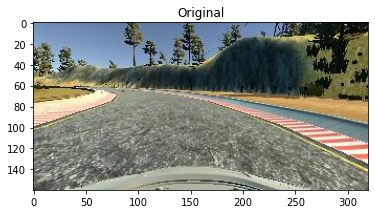

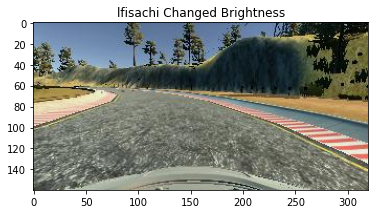

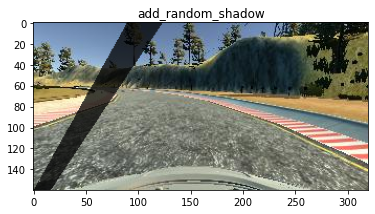

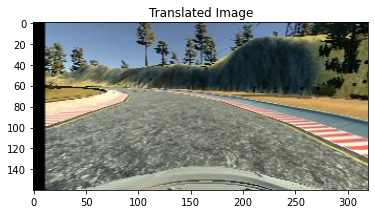

Original: 0.0 Modified: 0.04607674372107806


In [16]:
i = 0
images = list(os.listdir(img_path))

img = cv.imread(img_path+images[i])
angle = output[i]

img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
                
plt.imshow(img)
plt.title("Original")
plt.show()

# new_img = blur_image(img)
# plt.imshow(new_img)
# plt.title("Blurred")
# plt.show()

new_img = change_brightness(img)
plt.imshow(new_img)
plt.title("lfisachi Changed Brightness")
plt.show()

# new_img = change_image_brightness_rgb(img)
# plt.imshow(new_img)
# plt.title("Changed Brightness")
# plt.show()

new_img = add_random_shadow(img)
plt.imshow(new_img)
plt.title("add_random_shadow")
plt.show()

new_img,new_angle = trans_image(img,angle)
plt.imshow(new_img)
plt.title("Translated Image")
plt.show()
print("Original:",angle,"Modified:",new_angle)

# Dataset Generator Function

In [17]:
header = ["center","left","right","steering","throttle","break","speed"]
IMG_SHAPE = (66,200,3)

def generate_dataset(size):
    
    # read csv file column values
    df = pd.read_csv(base_path + "driving_log.csv")
    df.columns = header
    
    # GET THE PATHS TO IMAGES IN OUR DIRECTORY
    img_paths = list(df[['left','right','center']].values)
    for i in range(0,len(img_paths)):
        for j in range(0,3):
            img_paths[i][j] = img_paths[i][j].split("IMG")[1][1:]

            
    # GET THE OUTPUT STEERING ANGLES VALUES
    output = np.array(df['steering'].values)
    
    
    data_X = np.empty((size,66,200,3))
    data_Y = np.empty((size))
    
    for i in range(0,size):
        angle = output[i]
        random_index = np.random.choice(3)
        img = read_image(base_path+"IMG/"+img_paths[i][random_index])

        if random_index == 0:        # In Left Image it looks like we need to go right 
            angle += 0.2
        elif random_index == 1:       # STRESSING ON GOING LEFT IF WE ARE TOWARDS right track which seems to be so in right cam images
            angle -= 0.2

        img = crop_image(img)
        img = resize_image(img)
        img , angle = flip_image(img,angle)
        
        img,angle = trans_image(img,angle)
        img = change_brightness(img)
#         img = change_image_brightness_rgb(img)
        img = add_random_shadow(img)
        img = blur_image(img)

        data_X[i] = img
        data_Y[i] = angle

    cv.destroyAllWindows()
    return data_X,data_Y

# Getting Dataset 

(1000, 66, 200, 3)
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


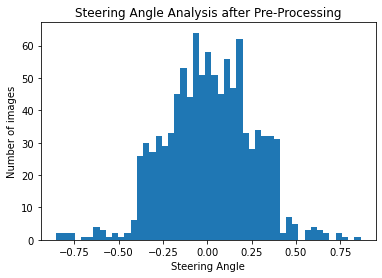

In [18]:
size = 1000
X_train , y_train = generate_dataset(size)

print(X_train.shape)
print(X_train[5,10,0:5,:])

temp = pd.DataFrame(y_train)
temp.columns = ["steering"]
binwidth = 0.035

# histogram before image augmentation
plt.hist(temp.steering,bins=np.arange(min(temp.steering), max(temp.steering) + binwidth, binwidth))
plt.title('Steering Angle Analysis after Pre-Processing')
plt.xlabel('Steering Angle')
plt.ylabel('Number of images')
plt.show()


# Converting the input to proper shape since CNN requires 4 Dimensional input 

In [19]:
print(X_train.shape,y_train.shape)                       
X_train = X_train.reshape( size,66,200, 3) 
y_train = y_train.reshape(y_train.shape[0], 1)           
print(X_train.shape,y_train.shape)      


(1000, 66, 200, 3) (1000,)
(1000, 66, 200, 3) (1000, 1)


# Making a function that will store best model trained

In [337]:
val_checkpoint = ModelCheckpoint('./models/model_Val_Loss-{val_loss:.4f}.h5',
                             monitor = 'val_loss',
                             save_best_only = True,
                             mode = 'auto' ) 

loss_checkpoint = ModelCheckpoint('./models/model_Loss-{loss:.4f}.h5',
                             monitor = 'loss',
                             save_best_only = True,
                             mode = 'auto'
                             )


# Simple Function to Get Data

In [397]:
from sklearn.model_selection import train_test_split 

def get_data(size,normalize = False):
    
    # Get Data
    X_train , y_train = generate_dataset(size)
    
    # Split the Dataset 
    X_train, X_test, y_train, y_test = train_test_split(X_train,y_train,test_size = 0.1) 
    
    # Normalize the data
    if normalize:
        X_train = X_train/255.0
        X_test = X_test/255.0 
    
    return X_train, X_test, y_train, y_test

In [405]:
X_train, X_test, y_train, y_test = get_data(2500,normalize = True) 

print(X_train[0][0][:5])


[[0.16470588 0.15686275 0.10196078]
 [0.18823529 0.17254902 0.10980392]
 [0.14117647 0.12156863 0.05882353]
 [0.0627451  0.05098039 0.        ]
 [0.04313725 0.04705882 0.00392157]]


# Training

In [406]:
# Get Model
model = get_model() 


# Make Checkpoints
val_checkpoint = ModelCheckpoint('./models/model_Val_Loss-{val_loss:.4f}.h5',
                             monitor = 'val_loss',
                             save_best_only = True,
                             mode = 'auto' ) 

loss_checkpoint = ModelCheckpoint('./models/model_Loss-{loss:.4f}.h5',
                             monitor = 'loss',
                             save_best_only = True,
                             mode = 'auto'
                             ) 


Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_122 (Conv2D)          (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_124 (Conv2D)          (None, 6, 22, 48)         27696     
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 4, 20, 64)         27712     
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 2, 18, 64)         36928     
_________________________________________________________________
flatten_24 (Flatten)         (None, 2304)              0         
_________________________________________________________________
dense_92 (Dense)             (None, 100)             

In [409]:
# Checking if the normalization worked or not
print(X_train[0][0][:5])


[[0.16470588 0.15686275 0.10196078]
 [0.18823529 0.17254902 0.10980392]
 [0.14117647 0.12156863 0.05882353]
 [0.0627451  0.05098039 0.        ]
 [0.04313725 0.04705882 0.00392157]]


# Training

In [410]:
from keras import backend as K

K.set_value(model.optimizer.learning_rate, 0.0001)
model.fit( X_train, y_train, 
           batch_size=32, epochs=20, 
           validation_data=(X_test, y_test), 
           callbacks=[val_checkpoint,loss_checkpoint],  
           shuffle=True )


Train on 2250 samples, validate on 250 samples
Epoch 1/20
2250/2250 [==============================] - 16s 7ms/step - loss: 0.0534 - val_loss: 0.0436
Epoch 2/20
2250/2250 [==============================] - 14s 6ms/step - loss: 0.0429 - val_loss: 0.0401
Epoch 3/20
2250/2250 [==============================] - 15s 7ms/step - loss: 0.0394 - val_loss: 0.0397
Epoch 4/20
2250/2250 [==============================] - 15s 7ms/step - loss: 0.0370 - val_loss: 0.0371
Epoch 5/20
2250/2250 [==============================] - 14s 6ms/step - loss: 0.0347 - val_loss: 0.0356
Epoch 6/20
2250/2250 [==============================] - 15s 7ms/step - loss: 0.0331 - val_loss: 0.0351
Epoch 7/20
2250/2250 [==============================] - 14s 6ms/step - loss: 0.0305 - val_loss: 0.0331
Epoch 8/20
2250/2250 [==============================] - 15s 7ms/step - loss: 0.0294 - val_loss: 0.0342
Epoch 9/20
2250/2250 [==============================] - 15s 7ms/step - loss: 0.0277 - val_loss: 0.0335
Epoch 10/20
2250/2250 [===

In [411]:
K.set_value(model.optimizer.learning_rate, 0.00005)
model.fit( X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test),callbacks=[val_checkpoint,loss_checkpoint], shuffle=True )

K.set_value(model.optimizer.learning_rate, 0.000007)
model.fit( X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test),callbacks=[val_checkpoint,loss_checkpoint], shuffle=True )


Train on 2250 samples, validate on 250 samples
Epoch 1/10
2250/2250 [==============================] - 14s 6ms/step - loss: 0.0124 - val_loss: 0.0324
Epoch 2/10
2250/2250 [==============================] - 14s 6ms/step - loss: 0.0118 - val_loss: 0.0326
Epoch 3/10
2250/2250 [==============================] - 14s 6ms/step - loss: 0.0109 - val_loss: 0.0321
Epoch 4/10
2250/2250 [==============================] - 14s 6ms/step - loss: 0.0103 - val_loss: 0.0319
Epoch 5/10
2250/2250 [==============================] - 14s 6ms/step - loss: 0.0098 - val_loss: 0.0325
Epoch 6/10
2250/2250 [==============================] - 14s 6ms/step - loss: 0.0096 - val_loss: 0.0325
Epoch 7/10
2250/2250 [==============================] - 14s 6ms/step - loss: 0.0089 - val_loss: 0.0323
Epoch 8/10
2250/2250 [==============================] - 14s 6ms/step - loss: 0.0084 - val_loss: 0.0328
Epoch 9/10
2250/2250 [==============================] - 14s 6ms/step - loss: 0.0081 - val_loss: 0.0331
Epoch 10/10
2250/2250 [===

# Running Simulation of Images we have

In [20]:
img_paths = np.array(df[['center','left','right']].values)
print(len(img_paths))

cnt = 1
i=0
while(1):
    cnt += 1
    i+=10
    if cnt>5000 or cnt>len(img_paths)-2:
        break
    path = base_path + "IMG/" + img_paths[i][1].split("IMG")[1][1:] 
    
    try:
        img = cv.imread(path)
        img = np.array(img)

        cv.imshow("Original Image",img)
        img = img[62:-25,:]
        
        img = cv.resize(img,(200,66))
        img = cv.flip(img,1)

        if i%200==0:
            print(i)
        cv.imshow('Cropped IMAGE',img)
        if cv.waitKey(50) == ord('e'):
            break
    except:
        continue

cv.destroyAllWindows()

10614
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
